In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read Files

In [3]:
# normalized data, with GA effect
#data = pd.read_csv("esetSC2_normalized.csv")

# data here is normalized, and the GA effect is removed.
data = pd.read_csv("esetSC2_remove_effect.csv")

# data information
data_info = pd.read_csv('anoSC2_v20_nokey.csv')

# GA information
GA_info = pd.read_csv("allSamplesSC1and2.csv")

GA_infomation = GA_info.set_index("SampleID")
GA_infomation = GA_infomation.loc[data.columns]
data_infomation = data_info.reset_index().set_index("SampleID").drop(columns = 'index')
data_infomation = data_infomation.loc[data.columns]
data_infomation = data_infomation[(data_infomation['Group']=='Control') | (data_infomation['Group']=='sPTD')]
data = data[data_infomation.index]
data_copy = data

## Split the data into train and test

In [4]:
def SampleList_To_Group(sample_list, data_infomation = data_infomation):
    control_sample = []
    sPTD_sample = []
    sample_group = []
    for sample in sample_list:
        group = data_infomation.loc[[sample]][['Group']].values[0][0]
        if group == 'Control':
            control_sample.append(sample)
            sample_group.append('Control')
        if group == 'sPTD':
            sPTD_sample.append(sample)
            sample_group.append('sPTD')
    return sample_group, control_sample, sPTD_sample

In [5]:
sample_list = list(data.columns)
sample_group, control_sample, sPTD_sample = SampleList_To_Group(sample_list)
xtrain,xtest,ytrain,ytest = train_test_split(data.transpose(), sample_group,test_size=0.2, random_state=1)

## Calculate the "similarity score" by t-test

In [6]:
control_sample = []
sPTD_sample = []
sapmles = list(xtrain.index)
sample_group, control_sample, sPTD_sample = SampleList_To_Group(sapmles)
sPTD_data = xtrain.transpose()[control_sample + sPTD_sample]

In [7]:
df = sPTD_data
df[['Control_mean', 'Control_std']] = df[control_sample].agg(['mean', 'std'], axis=1)
df[['sPTD_mean', 'sPTD_std']] = df[sPTD_sample].agg(['mean', 'std'], axis=1)
def welch_t_test(row):
    return (
        (row['Control_mean'] - row['sPTD_mean']) / 
        np.sqrt(row['Control_std']/len(control_sample) + row['sPTD_std']/len(sPTD_sample))
    )
df['similarity'] = df[['Control_mean', 'Control_std', 'sPTD_mean', 'sPTD_std']].apply(welch_t_test, axis=1)
df['similarity_abs'] = abs(df['similarity'])
df_sorted = df.sort_values('similarity_abs',ascending=False)
df_sorted.head()

,GSM1437892,GSM1437987,GSM1438066,GSM1437983,GSM1437941,GSM1437829,GSM1437817,GSM1438063,GSM1438002,GSM1438008,...,GSM1437809,GSM1437861,GSM1438078,GSM1437977,Control_mean,Control_std,sPTD_mean,sPTD_std,similarity,similarity_abs
28475_at,10.927796,10.622949,16.786358,12.513802,11.687113,11.734975,17.839968,17.555926,10.716478,11.599710,...,10.672335,17.283329,17.153530,19.651149,13.769581,3.104237,12.302076,2.936439,3.926370,3.926370
5197_at,4.379447,5.756558,6.201667,2.869651,5.771499,4.837062,5.242057,6.099754,4.202958,5.567539,...,5.783276,4.597003,5.136779,6.769016,5.185247,0.929886,6.003840,1.002524,-3.777224,3.777224
28423_at,7.427628,6.946946,5.184505,6.680152,6.467969,7.557324,7.726022,7.557580,5.841802,7.465034,...,5.299025,5.283407,6.292746,6.743339,7.190665,0.916055,6.431157,0.904084,3.671745,3.671745
100049587_at,10.095115,10.100637,10.107522,9.017047,9.467271,10.066821,9.904008,9.879690,10.258250,9.195873,...,9.864415,4.787964,9.498502,9.985095,9.465825,1.214374,8.190737,2.811305,3.622145,3.622145
28500_at,5.904413,5.068874,3.861399,6.257752,5.452482,5.588467,4.864656,5.031872,4.254139,7.035852,...,3.805455,4.765666,3.543674,4.786629,5.593747,0.966411,4.931397,0.918202,3.169997,3.169997


## Split the data into different GA Group

In [8]:
data_infomation_train = data_infomation.loc[xtrain.index]
GA_values = np.unique(data_infomation_train.loc[df_sorted.columns[:-5]][['GA']].values)
GA_values = [x for x in GA_values if str(x) != 'nan']
df_dict_GA = {}
for key in GA_values:
    GA_samples = data_infomation_train.loc[data_infomation_train['GA']==key].index
    df_dict_GA[key] = GA_samples.tolist()   
df  = df_sorted.drop(columns=['Control_mean', 'Control_std', 'sPTD_mean', 'sPTD_std', 'similarity','similarity_abs'])
for key in df_dict_GA:
    df_dict_GA[key] = df[df_dict_GA[key]]
df_dict_GA[18.0].head()

,GSM1437942,GSM1438117,GSM1437815,GSM1437860,GSM1437891,GSM1437874,GSM1437858,GSM1438009,GSM1438005,GSM1437803,GSM1437953,GSM1437825,GSM1437832,GSM1438091,GSM1438075,GSM1437821,GSM1437975,GSM1437971
28475_at,11.471692,18.030960,17.841554,17.409383,12.067329,11.270108,18.004256,11.108813,11.822327,16.567179,11.854990,12.936526,16.964773,17.530485,11.193883,14.384933,11.216214,10.276991
5197_at,6.969366,4.044957,4.657011,4.953781,5.065897,6.249688,6.090182,5.399519,5.693843,3.960510,5.882891,5.527117,3.940423,5.328847,5.936492,5.797686,5.229343,4.450307
28423_at,7.508211,8.480147,5.777896,6.271852,6.883952,6.779961,7.904906,7.769330,5.854501,5.505913,6.754667,7.382959,8.315530,7.503981,7.627564,5.521516,7.087781,7.310241
100049587_at,10.047505,8.935898,9.008933,3.433311,9.940158,9.907694,9.962782,9.852314,9.878640,9.735309,9.759202,10.046166,9.749360,9.816567,9.993136,9.918344,10.503351,9.949638
28500_at,5.618190,6.929401,5.331462,5.591841,6.887530,6.514006,6.360478,5.559615,4.891637,5.511489,4.281042,7.207372,6.290181,6.047939,6.179962,4.919565,5.414465,4.057818


This code take a long time to run, I save the result as txt file.

In [9]:
'''invalid_key = []
for key in df_dict_GA:
    sample_group, control_sample, sPTD_sample = SampleList_To_Group(df_dict_GA[key])
    if len(control_sample)>0 and len(sPTD_sample)>0:
        df_dict_GA[key][['Control_mean', 'Control_std']] = df_dict_GA[key][control_sample].agg(['mean', 'std'], axis=1)
        df_dict_GA[key][['sPTD_mean', 'sPTD_std']] = df_dict_GA[key][sPTD_sample].agg(['mean', 'std'], axis=1)
        df_dict_GA[key]['similarity'] = df_dict_GA[key][['Control_mean', 'Control_std', 'sPTD_mean', 'sPTD_std']].apply(welch_t_test, axis=1)
        df_dict_GA[key]['similarity_abs'] = abs(df_dict_GA[key]['similarity'])
        df_dict_GA[key] = df_dict_GA[key].sort_values('similarity_abs',ascending=False)
    else:
        invalid_key.append(key)
for key in invalid_key:
    df_dict_GA.pop(key)
df_dict_GA[18.0].head()'''

"invalid_key = []\nfor key in df_dict_GA:\n    sample_group, control_sample, sPTD_sample = SampleList_To_Group(df_dict_GA[key])\n    if len(control_sample)>0 and len(sPTD_sample)>0:\n        df_dict_GA[key][['Control_mean', 'Control_std']] = df_dict_GA[key][control_sample].agg(['mean', 'std'], axis=1)\n        df_dict_GA[key][['sPTD_mean', 'sPTD_std']] = df_dict_GA[key][sPTD_sample].agg(['mean', 'std'], axis=1)\n        df_dict_GA[key]['similarity'] = df_dict_GA[key][['Control_mean', 'Control_std', 'sPTD_mean', 'sPTD_std']].apply(welch_t_test, axis=1)\n        df_dict_GA[key]['similarity_abs'] = abs(df_dict_GA[key]['similarity'])\n        df_dict_GA[key] = df_dict_GA[key].sort_values('similarity_abs',ascending=False)\n    else:\n        invalid_key.append(key)\nfor key in invalid_key:\n    df_dict_GA.pop(key)\ndf_dict_GA[18.0].head()"

In [10]:
#pickle.dump(df_dict_GA,open('df_dict_GA_1.txt', 'wb')) # save the result
df_dict_GA=pickle.load(open('df_dict_GA_1.txt', 'rb'))
df_dict_GA[18.0].head()

,GSM1437942,GSM1438117,GSM1437815,GSM1437860,GSM1437891,GSM1437874,GSM1437858,GSM1438009,GSM1438005,GSM1437803,...,GSM1438075,GSM1437821,GSM1437975,GSM1437971,Control_mean,Control_std,sPTD_mean,sPTD_std,similarity,similarity_abs
170482_at,1.822535,2.982182,3.289308,1.780016,4.238558,3.404386,2.886408,3.386754,2.260372,3.213468,...,3.586661,3.216322,4.048760,3.151767,3.340555,0.560342,1.801275,0.030065,6.880155,6.880155
100885782_at,4.495955,2.229202,2.134965,4.248572,2.138916,2.191321,2.380051,2.401897,2.543776,2.392145,...,1.802545,2.038199,2.577303,2.806673,2.302213,0.239020,4.372263,0.174926,-6.468847,6.468847
105375752_at,4.619810,3.794938,3.489953,4.654763,3.544330,3.648879,4.127187,4.089435,3.513216,3.849650,...,3.923647,3.955590,3.294621,3.653713,3.724776,0.226788,4.637287,0.024716,-5.602110,5.602110
7134_at,3.801774,4.481491,5.032845,3.816327,4.477059,5.003245,4.496455,4.250205,4.799849,4.826021,...,4.512087,4.474627,4.440534,4.403178,4.557424,0.248593,3.809050,0.010291,5.203753,5.203753
106480634_at,2.007326,1.164631,0.952350,2.008255,1.220960,0.984871,1.549189,0.833630,1.117393,1.065989,...,1.865295,1.408643,1.559815,1.409930,1.295033,0.304822,2.007790,0.000657,-5.119959,5.119959


## Preliminary Feature Selection: Choose genes with high t-test score in different GA and all GAs

Select genes: local similarity >= 3 (in different GA) and global similarity >= 2 (in all GA)

In [11]:
gene_similarity = []
for key in df_dict_GA:
    df = df_dict_GA[key]
    gene = df.loc[df["similarity_abs"] >= 3].index.tolist()
    gene_similarity = gene_similarity + gene
gene = sPTD_data.loc[df_sorted["similarity_abs"] >= 2].index.tolist()
gene_similarity = gene_similarity + gene
gene_similarity = np.unique(gene_similarity)
print(len(gene_similarity))
#print(gene_similarity)

494


In [12]:
xtrain = xtrain[gene_similarity]
xtest = xtest[gene_similarity]

## Prediction

In [13]:
# FROM SKLEARN DOCS: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

# THIS FUNCTION DOES NOT WORK WELL WITH ONLY 2 CLASSES

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(cm.shape)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(-0.5, cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## K-Nearest Neighbors

Confusion matrix, without normalization
[[ 2  2]
 [ 0 47]]
(2, 2)


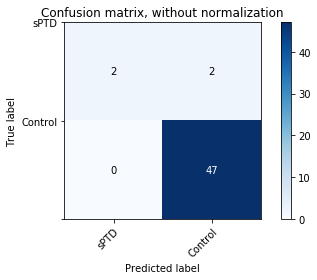

In [14]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Random Forest

Confusion matrix, without normalization
[[ 0  4]
 [ 0 47]]
(2, 2)


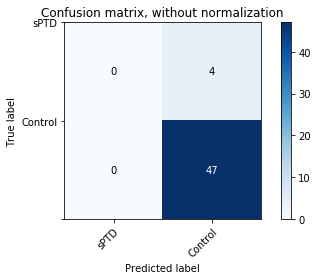

In [15]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Gaussian Naive Bayes

Confusion matrix, without normalization
[[ 0  4]
 [ 5 42]]
(2, 2)


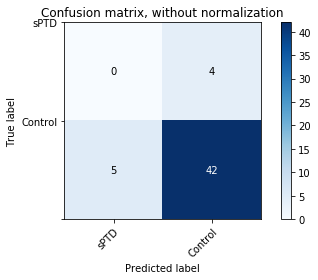

In [16]:
clf = GaussianNB()
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Support Vector Machine

Confusion matrix, without normalization
[[ 0  4]
 [ 0 47]]
(2, 2)


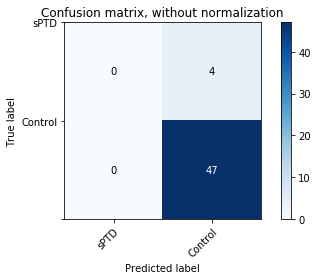

In [17]:
clf = svm.SVC(gamma='scale')
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Logistic Regression

Confusion matrix, without normalization
[[ 0  4]
 [ 0 47]]
(2, 2)


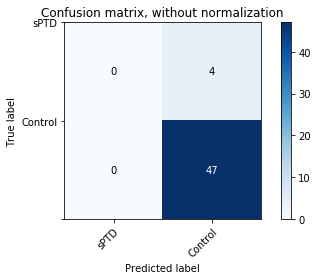

In [18]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Linear Discriminant Analysis

Confusion matrix, without normalization
[[ 1  3]
 [ 3 44]]
(2, 2)


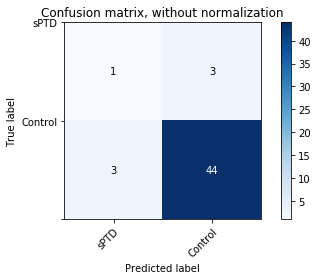

In [19]:
clf = LDA()
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Feature Selection: Recursive Feature Elimination

In [20]:
# Cross Validation
def Cross_Validation(df = xtrain):
    kf = KFold(n_splits=5)
    train_set_list = []
    validation_set_list = []
    for train_set, validation_set in kf.split(df):
        train_set = df.iloc[train_set]
        validation_set = df.iloc[validation_set]
        train_set_list.append(train_set)
        validation_set_list.append(validation_set)
    return train_set_list, validation_set_list

## K-Nearest Neighbors

In [21]:
def prediction_knn(features, df = xtrain, y = ytrain):
    df = df[features]
    total_error_ = []
    train_set_list, validation_set_list = Cross_Validation(df)
    clf = KNeighborsClassifier(n_neighbors=1)
    for i in range(len(train_set_list)):
        train = train_set_list[i]
        test = validation_set_list[i]
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(train.index))
        y_train = sample_group
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(test.index))
        y_test = sample_group
        clf.fit(train, y_train)
        pred = clf.predict(test).tolist()
        error = 0
        for i in range(len(pred)):
            if y_test[i] != pred[i]:
                error += 1
        total_error_.append(error)
    total_error = np.sum(total_error_)
    sample_number = df.shape[0]
    error_rate =  total_error/sample_number
    return error_rate

In [22]:
rfe_lib = {}
feature_lib = {}
feature_number = xtrain.shape[0]
df = xtrain
for n_features_to_select in range(1,feature_number):
    clf = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(df, ytrain)
    Features = df.columns[rfe.support_]
    error_rate = prediction_knn(features = Features)
    rfe_lib[n_features_to_select] = error_rate
    feature_lib[n_features_to_select] = Features
p1 = list(rfe_lib.keys())
best_genes_numbers = p1.index(min(p1))+1
genes = list(feature_lib[best_genes_numbers])
clf = KNeighborsClassifier(n_neighbors=1)
xtrain_FS = xtrain[genes]
xtest_FS = xtest[genes]
clf.fit(xtrain_FS, ytrain)
knn_predict = clf.predict(xtest_FS)
prediction = list(knn_predict)
result = ytest
error_num = 0
for i in range(len(prediction)):
    if prediction[i] == result[i]:
        pass
    else:
        error_num = error_num+1
positive_number = 0        
negative_number = 0
TP_number = 0
TN_number = 0
for i in range(len(prediction)):
    if result[i] == 'Control':
        positive_number = positive_number+1
        if prediction[i] == result[i]:
            TP_number = TP_number+1
    if result[i] == 'sPTD':
        negative_number = negative_number+1
        if prediction[i] == result[i]:
            TN_number = TN_number+1
TP_rate = TP_number/positive_number
TN_rate = TN_number/negative_number
print(TP_rate)
print(TN_rate)
print(error_num)

0.9148936170212766
0.0
8


## Random Forest

In [23]:
def prediction_rf(features, df = xtrain, y = ytrain):
    df = df[features]
    total_error_ = []
    train_set_list, validation_set_list = Cross_Validation(df)
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    for i in range(len(train_set_list)):
        train = train_set_list[i]
        test = validation_set_list[i]
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(train.index))
        y_train = sample_group
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(test.index))
        y_test = sample_group
        clf.fit(train, y_train)
        pred = clf.predict(test).tolist()
        error = 0
        for i in range(len(pred)):
            if y_test[i] != pred[i]:
                error += 1
        total_error_.append(error)
    total_error = np.sum(total_error_)
    sample_number = df.shape[0]
    error_rate =  total_error/sample_number
    return error_rate

In [24]:
rfe_lib = {}
feature_lib = {}
feature_number = xtrain.shape[0]
df = xtrain
for n_features_to_select in range(1,feature_number):
    clf = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(df, ytrain)
    Features = df.columns[rfe.support_]
    error_rate = prediction_rf(features = Features)
    rfe_lib[n_features_to_select] = error_rate
    feature_lib[n_features_to_select] = Features
p1 = list(rfe_lib.keys())
best_genes_numbers = p1.index(min(p1))+1
genes = list(feature_lib[best_genes_numbers])
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
xtrain_FS = xtrain[genes]
xtest_FS = xtest[genes]
clf.fit(xtrain_FS, ytrain)
rf_predict = clf.predict(xtest_FS)
prediction = list(rf_predict)
result = ytest
error_num = 0
for i in range(len(prediction)):
    if prediction[i] == result[i]:
        pass
    else:
        error_num = error_num+1
positive_number = 0        
negative_number = 0
TP_number = 0
TN_number = 0
for i in range(len(prediction)):
    if result[i] == 'Control':
        positive_number = positive_number+1
        if prediction[i] == result[i]:
            TP_number = TP_number+1
    if result[i] == 'sPTD':
        negative_number = negative_number+1
        if prediction[i] == result[i]:
            TN_number = TN_number+1
TP_rate = TP_number/positive_number
TN_rate = TN_number/negative_number
print(TP_rate)
print(TN_rate)
print(error_num)

1.0
0.0
4


## Gaussian Naive Bayes

In [25]:
def prediction_gnb(features, df = xtrain, y = ytrain):
    df = df[features]
    total_error_ = []
    train_set_list, validation_set_list = Cross_Validation(df)
    clf = GaussianNB()
    for i in range(len(train_set_list)):
        train = train_set_list[i]
        test = validation_set_list[i]
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(train.index))
        y_train = sample_group
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(test.index))
        y_test = sample_group
        clf.fit(train, y_train)
        pred = clf.predict(test).tolist()
        error = 0
        for i in range(len(pred)):
            if y_test[i] != pred[i]:
                error += 1
        total_error_.append(error)
    total_error = np.sum(total_error_)
    sample_number = df.shape[0]
    error_rate =  total_error/sample_number
    return error_rate

In [26]:
rfe_lib = {}
feature_lib = {}
feature_number = xtrain.shape[0]
df = xtrain
for n_features_to_select in range(1,feature_number):
    clf = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(df, ytrain)
    Features = df.columns[rfe.support_]
    error_rate = prediction_gnb(features = Features)
    rfe_lib[n_features_to_select] = error_rate
    feature_lib[n_features_to_select] = Features
p1 = list(rfe_lib.keys())
best_genes_numbers = p1.index(min(p1))+1
genes = list(feature_lib[best_genes_numbers])
clf = GaussianNB()
xtrain_FS = xtrain[genes]
xtest_FS = xtest[genes]
clf.fit(xtrain_FS, ytrain)
gnb_predict = clf.predict(xtest_FS)
prediction = list(gnb_predict)
result = ytest
error_num = 0
for i in range(len(prediction)):
    if prediction[i] == result[i]:
        pass
    else:
        error_num = error_num+1
positive_number = 0        
negative_number = 0
TP_number = 0
TN_number = 0
for i in range(len(prediction)):
    if result[i] == 'Control':
        positive_number = positive_number+1
        if prediction[i] == result[i]:
            TP_number = TP_number+1
    if result[i] == 'sPTD':
        negative_number = negative_number+1
        if prediction[i] == result[i]:
            TN_number = TN_number+1
TP_rate = TP_number/positive_number
TN_rate = TN_number/negative_number
print(TP_rate)
print(TN_rate)
print(error_num)

1.0
0.0
4


## Support Vector Machine

In [27]:
def prediction_svm(features, df = xtrain, y = ytrain):
    df = df[features]
    total_error_ = []
    train_set_list, validation_set_list = Cross_Validation(df)
    clf = svm.SVC(gamma='scale')
    for i in range(len(train_set_list)):
        train = train_set_list[i]
        test = validation_set_list[i]
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(train.index))
        y_train = sample_group
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(test.index))
        y_test = sample_group
        clf.fit(train, y_train)
        pred = clf.predict(test).tolist()
        error = 0
        for i in range(len(pred)):
            if y_test[i] != pred[i]:
                error += 1
        total_error_.append(error)
    total_error = np.sum(total_error_)
    sample_number = df.shape[0]
    error_rate =  total_error/sample_number
    return error_rate

In [28]:
rfe_lib = {}
feature_lib = {}
feature_number = xtrain.shape[0]
df = xtrain
for n_features_to_select in range(1,feature_number):
    clf = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(df, ytrain)
    Features = df.columns[rfe.support_]
    error_rate = prediction_svm(features = Features)
    rfe_lib[n_features_to_select] = error_rate
    feature_lib[n_features_to_select] = Features
p1 = list(rfe_lib.keys())
best_genes_numbers = p1.index(min(p1))+1
genes = list(feature_lib[best_genes_numbers])
clf = svm.SVC(gamma='scale')
xtrain_FS = xtrain[genes]
xtest_FS = xtest[genes]
clf.fit(xtrain_FS, ytrain)
svm_predict = clf.predict(xtest_FS)
prediction = list(svm_predict)
result = ytest
error_num = 0
for i in range(len(prediction)):
    if prediction[i] == result[i]:
        pass
    else:
        error_num = error_num+1
positive_number = 0        
negative_number = 0
TP_number = 0
TN_number = 0
for i in range(len(prediction)):
    if result[i] == 'Control':
        positive_number = positive_number+1
        if prediction[i] == result[i]:
            TP_number = TP_number+1
    if result[i] == 'sPTD':
        negative_number = negative_number+1
        if prediction[i] == result[i]:
            TN_number = TN_number+1
TP_rate = TP_number/positive_number
TN_rate = TN_number/negative_number
print(TP_rate)
print(TN_rate)
print(error_num)

1.0
0.0
4


## Logistic Regression

In [29]:
def prediction_lg(features, df = xtrain, y = ytrain):
    df = df[features]
    total_error_ = []
    train_set_list, validation_set_list = Cross_Validation(df)
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    for i in range(len(train_set_list)):
        train = train_set_list[i]
        test = validation_set_list[i]
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(train.index))
        y_train = sample_group
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(test.index))
        y_test = sample_group
        clf.fit(train, y_train)
        pred = clf.predict(test).tolist()
        error = 0
        for i in range(len(pred)):
            if y_test[i] != pred[i]:
                error += 1
        total_error_.append(error)
    total_error = np.sum(total_error_)
    sample_number = df.shape[0]
    error_rate =  total_error/sample_number
    return error_rate

In [30]:
rfe_lib = {}
feature_lib = {}
feature_number = xtrain.shape[0]
df = xtrain
for n_features_to_select in range(1,feature_number):
    clf = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(df, ytrain)
    Features = df.columns[rfe.support_]
    error_rate = prediction_lg(features = Features)
    rfe_lib[n_features_to_select] = error_rate
    feature_lib[n_features_to_select] = Features
p1 = list(rfe_lib.keys())
best_genes_numbers = p1.index(min(p1))+1
genes = list(feature_lib[best_genes_numbers])
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
xtrain_FS = xtrain[genes]
xtest_FS = xtest[genes]
clf.fit(xtrain_FS, ytrain)
lg_predict = clf.predict(xtest_FS)
prediction = list(lg_predict)
result = ytest
error_num = 0
for i in range(len(prediction)):
    if prediction[i] == result[i]:
        pass
    else:
        error_num = error_num+1
positive_number = 0        
negative_number = 0
TP_number = 0
TN_number = 0
for i in range(len(prediction)):
    if result[i] == 'Control':
        positive_number = positive_number+1
        if prediction[i] == result[i]:
            TP_number = TP_number+1
    if result[i] == 'sPTD':
        negative_number = negative_number+1
        if prediction[i] == result[i]:
            TN_number = TN_number+1
TP_rate = TP_number/positive_number
TN_rate = TN_number/negative_number
print(TP_rate)
print(TN_rate)
print(error_num)

1.0
0.0
4


## Linear Discriminant Analysis

In [31]:
def prediction_lda(features, df = xtrain, y = ytrain):
    df = df[features]
    total_error_ = []
    train_set_list, validation_set_list = Cross_Validation(df)
    clf = LDA()
    for i in range(len(train_set_list)):
        train = train_set_list[i]
        test = validation_set_list[i]
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(train.index))
        y_train = sample_group
        sample_group, control_sample, sPTD_sample = SampleList_To_Group(list(test.index))
        y_test = sample_group
        clf.fit(train, y_train)
        pred = clf.predict(test).tolist()
        error = 0
        for i in range(len(pred)):
            if y_test[i] != pred[i]:
                error += 1
        total_error_.append(error)
    total_error = np.sum(total_error_)
    sample_number = df.shape[0]
    error_rate =  total_error/sample_number
    return error_rate

In [32]:
rfe_lib = {}
feature_lib = {}
feature_number = xtrain.shape[0]
df = xtrain
for n_features_to_select in range(1,feature_number):
    clf = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(df, ytrain)
    Features = df.columns[rfe.support_]
    error_rate = prediction_lda(features = Features)
    rfe_lib[n_features_to_select] = error_rate
    feature_lib[n_features_to_select] = Features
p1 = list(rfe_lib.keys())
best_genes_numbers = p1.index(min(p1))+1
genes = list(feature_lib[best_genes_numbers])
clf = LDA()
xtrain_FS = xtrain[genes]
xtest_FS = xtest[genes]
clf.fit(xtrain_FS, ytrain)
lda_predict = clf.predict(xtest_FS)
prediction = list(lda_predict)
result = ytest
error_num = 0
for i in range(len(prediction)):
    if prediction[i] == result[i]:
        pass
    else:
        error_num = error_num+1
positive_number = 0        
negative_number = 0
TP_number = 0
TN_number = 0
for i in range(len(prediction)):
    if result[i] == 'Control':
        positive_number = positive_number+1
        if prediction[i] == result[i]:
            TP_number = TP_number+1
    if result[i] == 'sPTD':
        negative_number = negative_number+1
        if prediction[i] == result[i]:
            TN_number = TN_number+1
TP_rate = TP_number/positive_number
TN_rate = TN_number/negative_number
print(TP_rate)
print(TN_rate)
print(error_num)

1.0
0.0
4
